In [128]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [129]:
data_dir = '../../DATA/ssc.hg38'
count_types = ['HCR', 'LCR']
colors = ['#ef6c00ff', '#4db6acff', '#b3a77dff', '#695d46ff', '#ce93d8ff', '#009668ff', ]

In [130]:
all_params = []
for i, count_type in enumerate(count_types):
    with open('%s/sequencing_error_rates/%s_errors.json' % (data_dir, count_type), 'r') as f:
        all_params.append(json.load(f))

# first pull individuals that exist in all params
individuals = set([k for k, v in all_params[0].items() if isinstance(v, dict)])
for p in all_params[1:]:
    individuals = individuals & set([k for k, v in p.items() if isinstance(v, dict)])

# for each individual, extrapolate deletion costs
gens = ['0/0', '0/1', '1/1', '0/-', '1/-']
obss = ['0/0', '0/1', '1/1', './.']

error_rates = np.zeros((len(count_types), len(individuals), len(gens), len(obss)))

def get_error_apply_lower_bound(p, gen, obs):
    key = '-log10(P[obs=%s|true_gen=%s])' % (obs, gen)
    #if ('lower_bound[%s]' % key in p) and (p['lower_bound[%s]' % key] is not None) and ~np.isnan(p['lower_bound[%s]' % key]):
    #	return min(p[key], p['lower_bound[%s]' % key])
    #else:
    return p[key]

for j, ind in enumerate(individuals):
    for i, p in enumerate(all_params):
        for k, gen in enumerate(gens[:3]):
            for l, obs in enumerate(obss):
                error_rates[i, j, k, l] = get_error_apply_lower_bound(p[ind], gen, obs)
        error_rates[i, j, 3, :] = error_rates[i, j, 0, :]
        error_rates[i, j, 4, :] = error_rates[i, j, 2, :]
        
error_rates = error_rates[:, ~np.any(np.isnan(error_rates), axis=(0, 2, 3)), :, :]
print(error_rates.shape)

(2, 9120, 5, 4)


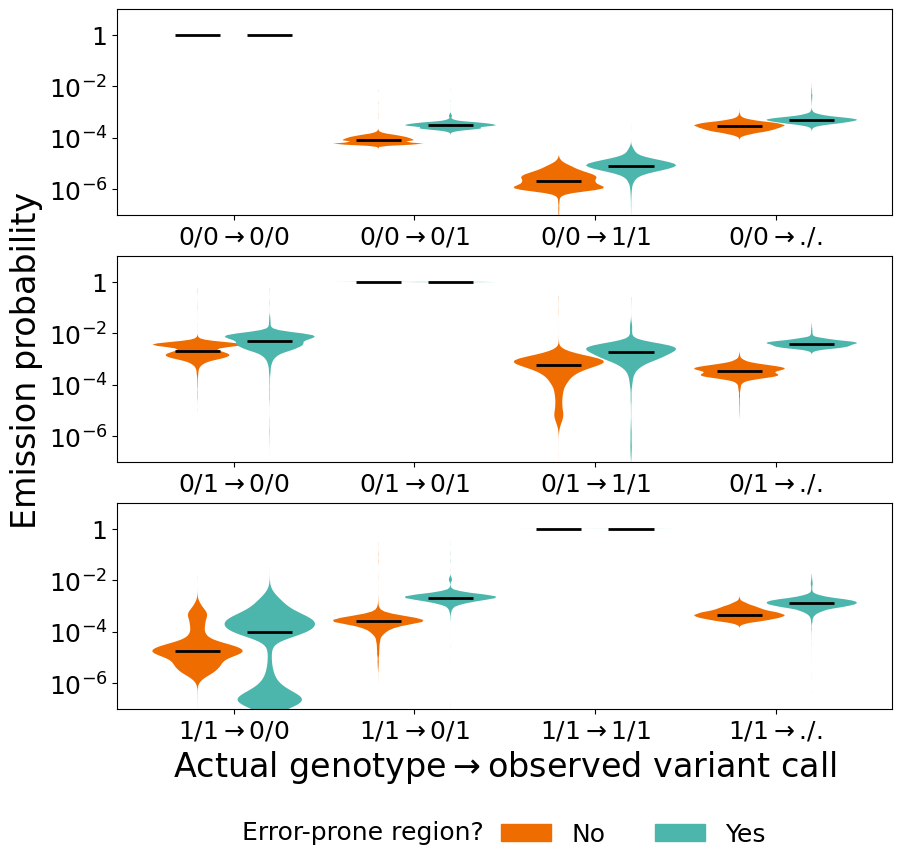

In [131]:
fig, subs = plt.subplots(3, 1, sharey=True, figsize=(10, 10))   

for i, gen in enumerate(gens[:3]):
    parts = subs[i].violinplot(-error_rates[0, :, i, :], np.arange(1, 5), showextrema=False, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(colors[0])
        #pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    parts = subs[i].violinplot(-error_rates[1, :, i, :], np.arange(1, 5)+0.4, showextrema=False, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(colors[1])
        #pc.set_edgecolor('black')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('black')
    parts['cmedians'].set_linewidth(2)
    
    subs[i].set_xticks(np.arange(1, 5)+0.2, [r'%s$\rightarrow$%s' % (gen, obs) for obs in obss], fontsize=18)
    subs[i].set_yticks(np.arange(-6, 2, 2), ['1' if d==0 else '$10^{%d}$'% d for d in np.arange(-6, 2, 2)], fontsize=18)
    if i==1:
        subs[i].set_ylabel('Emission probability', fontsize=24)
    if i==2:
        subs[i].set_xlabel(r'Actual genotype$\rightarrow$observed variant call', fontsize=24)
    subs[i].set_ylim([-7, 1])
    
entries = [patches.Patch(color=colors[0], label='No'), patches.Patch(color=colors[1], label='Yes')]
legend = subs[2].legend(handles=entries, ncol=2,
           bbox_to_anchor=(0.85, -0.5), borderaxespad=0., fontsize=18, frameon=False)
fig.text(0.25, 0.07, 'Error-prone region?', fontsize=18)
fig.subplots_adjust(wspace=0.0, hspace=0.2, top=0.9, bottom=0.2)
    
fig.savefig('../plots/emission.png', dpi=fig.dpi)
fig.savefig('../plots/Fig_15.png', dpi=fig.dpi)